In [19]:
import os, gc, sys
from glob import glob
from tqdm.notebook import tqdm
import itertools
import pandas as pd

import re

In [2]:
prefix = os.getcwd().split("jdi-qasp-ml")[0]
sys.path.append(os.path.join(prefix, "jdi-qasp-ml"))
model_path = os.path.join(prefix, "jdi-qasp-ml", "HTML5_model/model")
df_path = os.path.join(prefix, "jdi-qasp-ml", "data/html5_dataset/df")

In [184]:
ds_files = glob(f"{df_path}/html5*.pkl")
df = pd.DataFrame()
for file in tqdm(ds_files[:200]):
    df = pd.concat([df, pd.read_pickle(file)]).reset_index(drop=True)

df.to_parquet(f"{prefix}jdi-qasp-ml/data/html5_dataset/html5_full_dataset.parquet")

  0%|          | 0/200 [00:00<?, ?it/s]

In [192]:
df['label'] = df.attributes.apply(lambda x: None if (None if x is None else x.get("data-label")) is None else x.get("data-label")).fillna("n/a")
df['attributes_list'] = df.attributes.apply(lambda x: "" if x is None else " ".join(list(x.keys())))
df["type"] = df.attributes.apply(lambda x: None if (None if x is None else x.get("type")) is None else x.get("type")).fillna("n/a")

In [232]:
df[df.type=="month"].iloc[0]["html"]

'<input value="2012-07" min="2007-10" name="f3159348" data-label="datetimeselector" max="2024-05" style="color:#35910e; font-size:28px;" id="53e6f568" type="month" class="57ca071b">'

In [193]:
df.head(1)

,attributes,displayed,element_id,height,html,onmouseenter,onmouseover,parent_id,style,tag_name,text,width,x,y,label,attributes_list,type
0,{'lang': 'en'},True,8113341764402415952952366291,7965.359375,"<html lang=""en""><head>\n <meta charset=...",None,None,None,"[accent-color, align-content, align-items, ali...",HTML,Sport space production mean nature. Book qui...,1390.0,5.0,5.0,n/a,lang,n/a


In [513]:
dataset = df[["element_id", "tag_name", "attributes_list", "type", "label"]]

In [514]:
dataset.head()

,element_id,tag_name,attributes_list,type,label
0,8113341764402415952952366291,HTML,lang,n/a,n/a
1,1405490226402415955137792732,HEAD,,n/a,n/a
2,0130040213402415957494652564,META,charset,n/a,n/a
3,5609394549402415954259039598,TITLE,,n/a,n/a
4,6520436129402415956147996590,STYLE,,n/a,n/a


In [515]:
dataset[dataset.type=="radio"]

,element_id,tag_name,attributes_list,type,label
18,2298321508402415959205574320,INPUT,class data-label disabled font-size:28px; id n...,radio,radiobutton
19,0019641900402415954840917069,INPUT,class data-label disabled font-size:23px; id n...,radio,radiobutton
22,4157287732402415950145543562,INPUT,checked class data-label disabled font-size:16...,radio,radiobutton
24,0153377849402415951556216775,INPUT,class data-label disabled font-size:23px; id n...,radio,radiobutton
170,7290836609402415969489970402,INPUT,class data-label disabled font-size:16px; id n...,radio,radiobutton
...,...,...,...,...,...
168255,2162992470406385780600324059,INPUT,class data-label disabled font-size:22px; id n...,radio,radiobutton
168269,3565095568406385787724652713,INPUT,class data-label disabled font-size:19px; id n...,radio,radiobutton
168271,7915440865406385784426727000,INPUT,class data-label disabled font-size:17px; id n...,radio,radiobutton
168273,0196171495406385784871636710,INPUT,checked class data-label disabled font-size:14...,radio,radiobutton


In [516]:
df.label.unique()

array(['n/a', 'colorpicker', 'fileinput', 'link', 'radiobutton', 'range',
       'table', 'checkbox', 'progressbar', 'textarea', 'button',
       'textfield', 'dropdown', 'numberselector', 'datetimeselector',
       'selector'], dtype=object)

In [517]:
(dataset["type"].apply(lambda x: 1 if "radio" == x else 0)).sum()

9860

In [518]:
buf = re.sub(" +", " ", " ".join(dataset.attributes_list.to_list()))
attr_columns = list(set([i for i in set(buf.split(" ")) if "font-size" not in i]) - set(["data-label", "label", "id", "name", "type", "class", "style"]))
tag_columns = list(dataset.tag_name.unique())
type_columns = list(set(dataset.type.unique())-set(["n/a", "color"]))
print(attr_columns)
print(tag_columns)
print(type_columns)

['step', 'size', 'max', 'required', 'lang', 'list', 'maxlength', 'for', 'disabled', 'placeholder', 'checked', 'value', 'rows', 'minlength', 'charset', 'href', 'min', 'cols', 'accept']
['HTML', 'HEAD', 'META', 'TITLE', 'STYLE', 'BODY', 'DIV', 'LABEL', 'INPUT', 'A', 'P', 'DATALIST', 'TABLE', 'TBODY', 'TR', 'TD', 'BR', 'PROGRESS', 'TEXTAREA', 'BUTTON', 'OPTION', 'SELECT']
['date', 'radio', 'text', 'month', 'number', 'time', 'range', 'week', 'file', 'checkbox', 'datetime-local']


In [519]:
for col in tqdm(attr_columns):
    dataset.loc[:, "attr_"+col] = dataset.loc[:, "attributes_list"].apply(lambda x: 1 if col in x else 0).values

for col in tqdm(tag_columns):
    dataset.loc[:, "tag_"+col] = dataset.loc[:, "tag_name"].apply(lambda x: 1 if col == x else 0).values

for col in tqdm(type_columns):
    dataset.loc[:, "type_"+col] = dataset.loc[:, "type"].apply(lambda x: 1 if col == x else 0).values

attr_columns = ["attr_"+col for col in attr_columns]

tag_columns = ["tag_"+col for col in tag_columns]

type_columns = ["type_"+col for col in type_columns]


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/Mikhail_Bulgakov/opt/anaconda3/envs/jdi-qasp-ml/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [520]:
print(attr_columns)
print(tag_columns)
print(type_columns)

['attr_step', 'attr_size', 'attr_max', 'attr_required', 'attr_lang', 'attr_list', 'attr_maxlength', 'attr_for', 'attr_disabled', 'attr_placeholder', 'attr_checked', 'attr_value', 'attr_rows', 'attr_minlength', 'attr_charset', 'attr_href', 'attr_min', 'attr_cols', 'attr_accept']
['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE', 'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_A', 'tag_P', 'tag_DATALIST', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD', 'tag_BR', 'tag_PROGRESS', 'tag_TEXTAREA', 'tag_BUTTON', 'tag_OPTION', 'tag_SELECT']
['type_date', 'type_radio', 'type_text', 'type_month', 'type_number', 'type_time', 'type_range', 'type_week', 'type_file', 'type_checkbox', 'type_datetime-local']


In [521]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dataset["label"] = le.fit_transform(dataset["label"])

In [522]:
DF = dataset[tag_columns + attr_columns + type_columns + ["label"]]

In [523]:
pd.DataFrame({"classes":le.classes_, "codes": le.transform(le.classes_)})

,classes,codes
0,button,0
1,checkbox,1
2,colorpicker,2
3,datetimeselector,3
4,dropdown,4
5,fileinput,5
6,link,6
7,n/a,7
8,numberselector,8
9,progressbar,9


In [524]:
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [525]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy={i:30000 for i in le.transform(le.classes_) if i != 7})

In [526]:
X_train, X_test, y_train, y_test = train_test_split(DF.drop(columns=["label"]), DF.label, test_size=0.2)
X_over, y_over = ros.fit_resample(X_train, y_train)
print(X_train.shape)
print(X_over.shape)

(134768, 52)
(544921, 52)


In [527]:
X_train.columns

Index(['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE',
       'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_A', 'tag_P',
       'tag_DATALIST', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD', 'tag_BR',
       'tag_PROGRESS', 'tag_TEXTAREA', 'tag_BUTTON', 'tag_OPTION',
       'tag_SELECT', 'attr_step', 'attr_size', 'attr_max', 'attr_required',
       'attr_lang', 'attr_list', 'attr_maxlength', 'attr_for', 'attr_disabled',
       'attr_placeholder', 'attr_checked', 'attr_value', 'attr_rows',
       'attr_minlength', 'attr_charset', 'attr_href', 'attr_min', 'attr_cols',
       'attr_accept', 'type_date', 'type_radio', 'type_text', 'type_month',
       'type_number', 'type_time', 'type_range', 'type_week', 'type_file',
       'type_checkbox', 'type_datetime-local'],
      dtype='object')

In [528]:
print(X_test.shape)

(33693, 52)


In [529]:
X_train.columns

Index(['tag_HTML', 'tag_HEAD', 'tag_META', 'tag_TITLE', 'tag_STYLE',
       'tag_BODY', 'tag_DIV', 'tag_LABEL', 'tag_INPUT', 'tag_A', 'tag_P',
       'tag_DATALIST', 'tag_TABLE', 'tag_TBODY', 'tag_TR', 'tag_TD', 'tag_BR',
       'tag_PROGRESS', 'tag_TEXTAREA', 'tag_BUTTON', 'tag_OPTION',
       'tag_SELECT', 'attr_step', 'attr_size', 'attr_max', 'attr_required',
       'attr_lang', 'attr_list', 'attr_maxlength', 'attr_for', 'attr_disabled',
       'attr_placeholder', 'attr_checked', 'attr_value', 'attr_rows',
       'attr_minlength', 'attr_charset', 'attr_href', 'attr_min', 'attr_cols',
       'attr_accept', 'type_date', 'type_radio', 'type_text', 'type_month',
       'type_number', 'type_time', 'type_range', 'type_week', 'type_file',
       'type_checkbox', 'type_datetime-local'],
      dtype='object')

In [530]:
DecisionTreeClassifier()._get_param_names()

['ccp_alpha',
 'class_weight',
 'criterion',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'random_state',
 'splitter']

In [531]:
parameters = {'max_depth':range(10,20), 'criterion': ["gini", "entropy"], 'min_samples_split': range(2,5), 'min_samples_leaf': range(1,2)}
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=-1)
clf.fit(X=X_over, y=y_over)
tree_model = clf.best_estimator_

In [532]:
clf.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [533]:
print(classification_report(y_over, tree_model.predict(X_over), target_names=le.classes_))

                  precision    recall  f1-score   support

          button       1.00      1.00      1.00     30000
        checkbox       1.00      1.00      1.00     30000
     colorpicker       1.00      0.50      0.66     30000
datetimeselector       1.00      0.51      0.68     30000
        dropdown       1.00      1.00      1.00     30000
       fileinput       1.00      1.00      1.00     30000
            link       1.00      1.00      1.00     30000
             n/a       0.68      1.00      0.81     94921
  numberselector       1.00      1.00      1.00     30000
     progressbar       1.00      0.50      0.66     30000
     radiobutton       1.00      1.00      1.00     30000
           range       1.00      1.00      1.00     30000
        selector       1.00      1.00      1.00     30000
           table       1.00      1.00      1.00     30000
        textarea       1.00      1.00      1.00     30000
       textfield       1.00      1.00      1.00     30000

        accu

In [534]:
y_pred = tree_model.predict(X_test)

In [535]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred, target_names=le.classes_))

                  precision    recall  f1-score   support

          button       1.00      1.00      1.00       341
        checkbox       1.00      1.00      1.00      2479
     colorpicker       1.00      0.52      0.68       700
datetimeselector       1.00      0.46      0.63       749
        dropdown       1.00      1.00      1.00       364
       fileinput       1.00      1.00      1.00       361
            link       1.00      1.00      1.00       373
             n/a       0.96      1.00      0.98     23694
  numberselector       1.00      1.00      1.00       323
     progressbar       1.00      0.50      0.67       686
     radiobutton       1.00      1.00      1.00      2030
           range       1.00      1.00      1.00       348
        selector       1.00      1.00      1.00       317
           table       1.00      1.00      1.00       264
        textarea       1.00      1.00      1.00       309
       textfield       1.00      1.00      1.00       355

        accu

In [536]:
# print((y_pred[y_test != 7]))
# print((y_test[y_test != 7]))

In [537]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test[y_test != 7], y_pred[y_test != 7])

0.8918891889188919

In [538]:
test_res = pd.DataFrame({"y_test":y_test, "y_pred":y_pred, "label_test":le.inverse_transform(y_test), "label_pred":le.inverse_transform(y_pred)})
test_res["str"] = test_res.label_test+ "-" +test_res.label_pred

In [539]:
test_res[test_res.y_test != test_res.y_pred]

,y_test,y_pred,label_test,label_pred,str
43711,3,7,datetimeselector,n/a,datetimeselector-n/a
71027,9,7,progressbar,n/a,progressbar-n/a
154710,9,7,progressbar,n/a,progressbar-n/a
15814,3,7,datetimeselector,n/a,datetimeselector-n/a
142430,9,7,progressbar,n/a,progressbar-n/a
...,...,...,...,...,...
63758,9,7,progressbar,n/a,progressbar-n/a
89177,9,7,progressbar,n/a,progressbar-n/a
93657,3,7,datetimeselector,n/a,datetimeselector-n/a
23522,3,7,datetimeselector,n/a,datetimeselector-n/a


In [540]:
df[df.label.isin(["colorpicker", 'datetimeselctor'])]

,attributes,displayed,element_id,height,html,onmouseenter,onmouseover,parent_id,style,tag_name,text,width,x,y,label,attributes_list,type
7,"{'class': 'c72d760c', 'data-label': 'colorpick...",True,5948805266402415954561716277,17.0,"<label label=""colorpicker"" for=""8be36cbd"" styl...",None,None,0347116426402415951086477327,"[accent-color, align-content, align-items, ali...",LABEL,Sport space production mean nature.,238.156250,20.000000,27.000000,colorpicker,class data-label for id label name style,n/a
8,"{'class': '771c49a6', 'data-label': 'colorpick...",True,7513680666402415950984891269,27.0,"<input style=""color:#0f0f0f; font-size:22px;"" ...",None,None,0347116426402415951086477327,"[accent-color, align-content, align-items, ali...",INPUT,,50.000000,268.156250,20.000000,colorpicker,class data-label id name style type value,color
264,"{'class': '133d3c36', 'data-label': 'colorpick...",True,3907559234402415961627244927,17.0,"<label style=""color:#5c8206; font-size:16px;"" ...",None,None,0347116426402415951086477327,"[accent-color, align-content, align-items, ali...",LABEL,Where meeting return.,148.375000,136.625000,3231.406250,colorpicker,class data-label for id label name style,n/a
265,"{'class': 'fdece736', 'data-label': 'colorpick...",True,3406934861402415960475317773,27.0,"<input name=""3002a115"" value=""#e241e0"" type=""c...",None,None,0347116426402415951086477327,"[accent-color, align-content, align-items, ali...",INPUT,,50.000000,295.000000,3224.406250,colorpicker,class data-label disabled id name style type v...,color
298,"{'class': '14824e3d', 'data-label': 'colorpick...",True,3302269765402415963171309040,17.0,"<label style=""color:#161616; font-size:16px;"" ...",None,None,1862445078402415968246239838,"[accent-color, align-content, align-items, ali...",LABEL,Road food.,75.109375,34.000000,3898.406250,colorpicker,class data-label for id label name style,n/a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168351,"{'class': '71df38f8', 'data-label': 'colorpick...",True,5309989385406385781439491919,27.0,"<input style=""color:#027a46; font-size:21px;"" ...",None,None,3604523222406385781334311512,"[accent-color, align-content, align-items, ali...",INPUT,,50.000000,128.984375,12702.421875,colorpicker,class data-label id name style type,color
168383,"{'class': '03be45d1', 'data-label': 'colorpick...",True,6738373971406385780039920237,16.0,"<label label=""colorpicker"" id=""8055ae81"" class...",None,None,0832136628406385773620128459,"[accent-color, align-content, align-items, ali...",LABEL,Explain computer push Congress.,206.234375,20.000000,12993.031250,colorpicker,class data-label for id label name style,n/a
168384,"{'class': 'ca06b035', 'data-label': 'colorpick...",True,3897335297406385788927415042,27.0,"<input id=""28e099d2"" class=""ca06b035"" type=""co...",None,None,0832136628406385773620128459,"[accent-color, align-content, align-items, ali...",INPUT,,50.000000,236.234375,12985.031250,colorpicker,class data-label id name style type value,color
168449,"{'class': 'e001833c', 'data-label': 'colorpick...",True,0419610603406385782392527699,27.0,"<input value=""#f2e287"" name=""8926b8e6"" style=""...",None,None,0832136628406385773620128459,"[accent-color, align-content, align-items, ali...",INPUT,,50.000000,202.062500,14046.000000,colorpicker,class data-label disabled id name style type v...,color


In [541]:
test_res[test_res.y_test != test_res.y_pred].str.unique()

array(['datetimeselector-n/a', 'progressbar-n/a', 'colorpicker-n/a'],
      dtype=object)

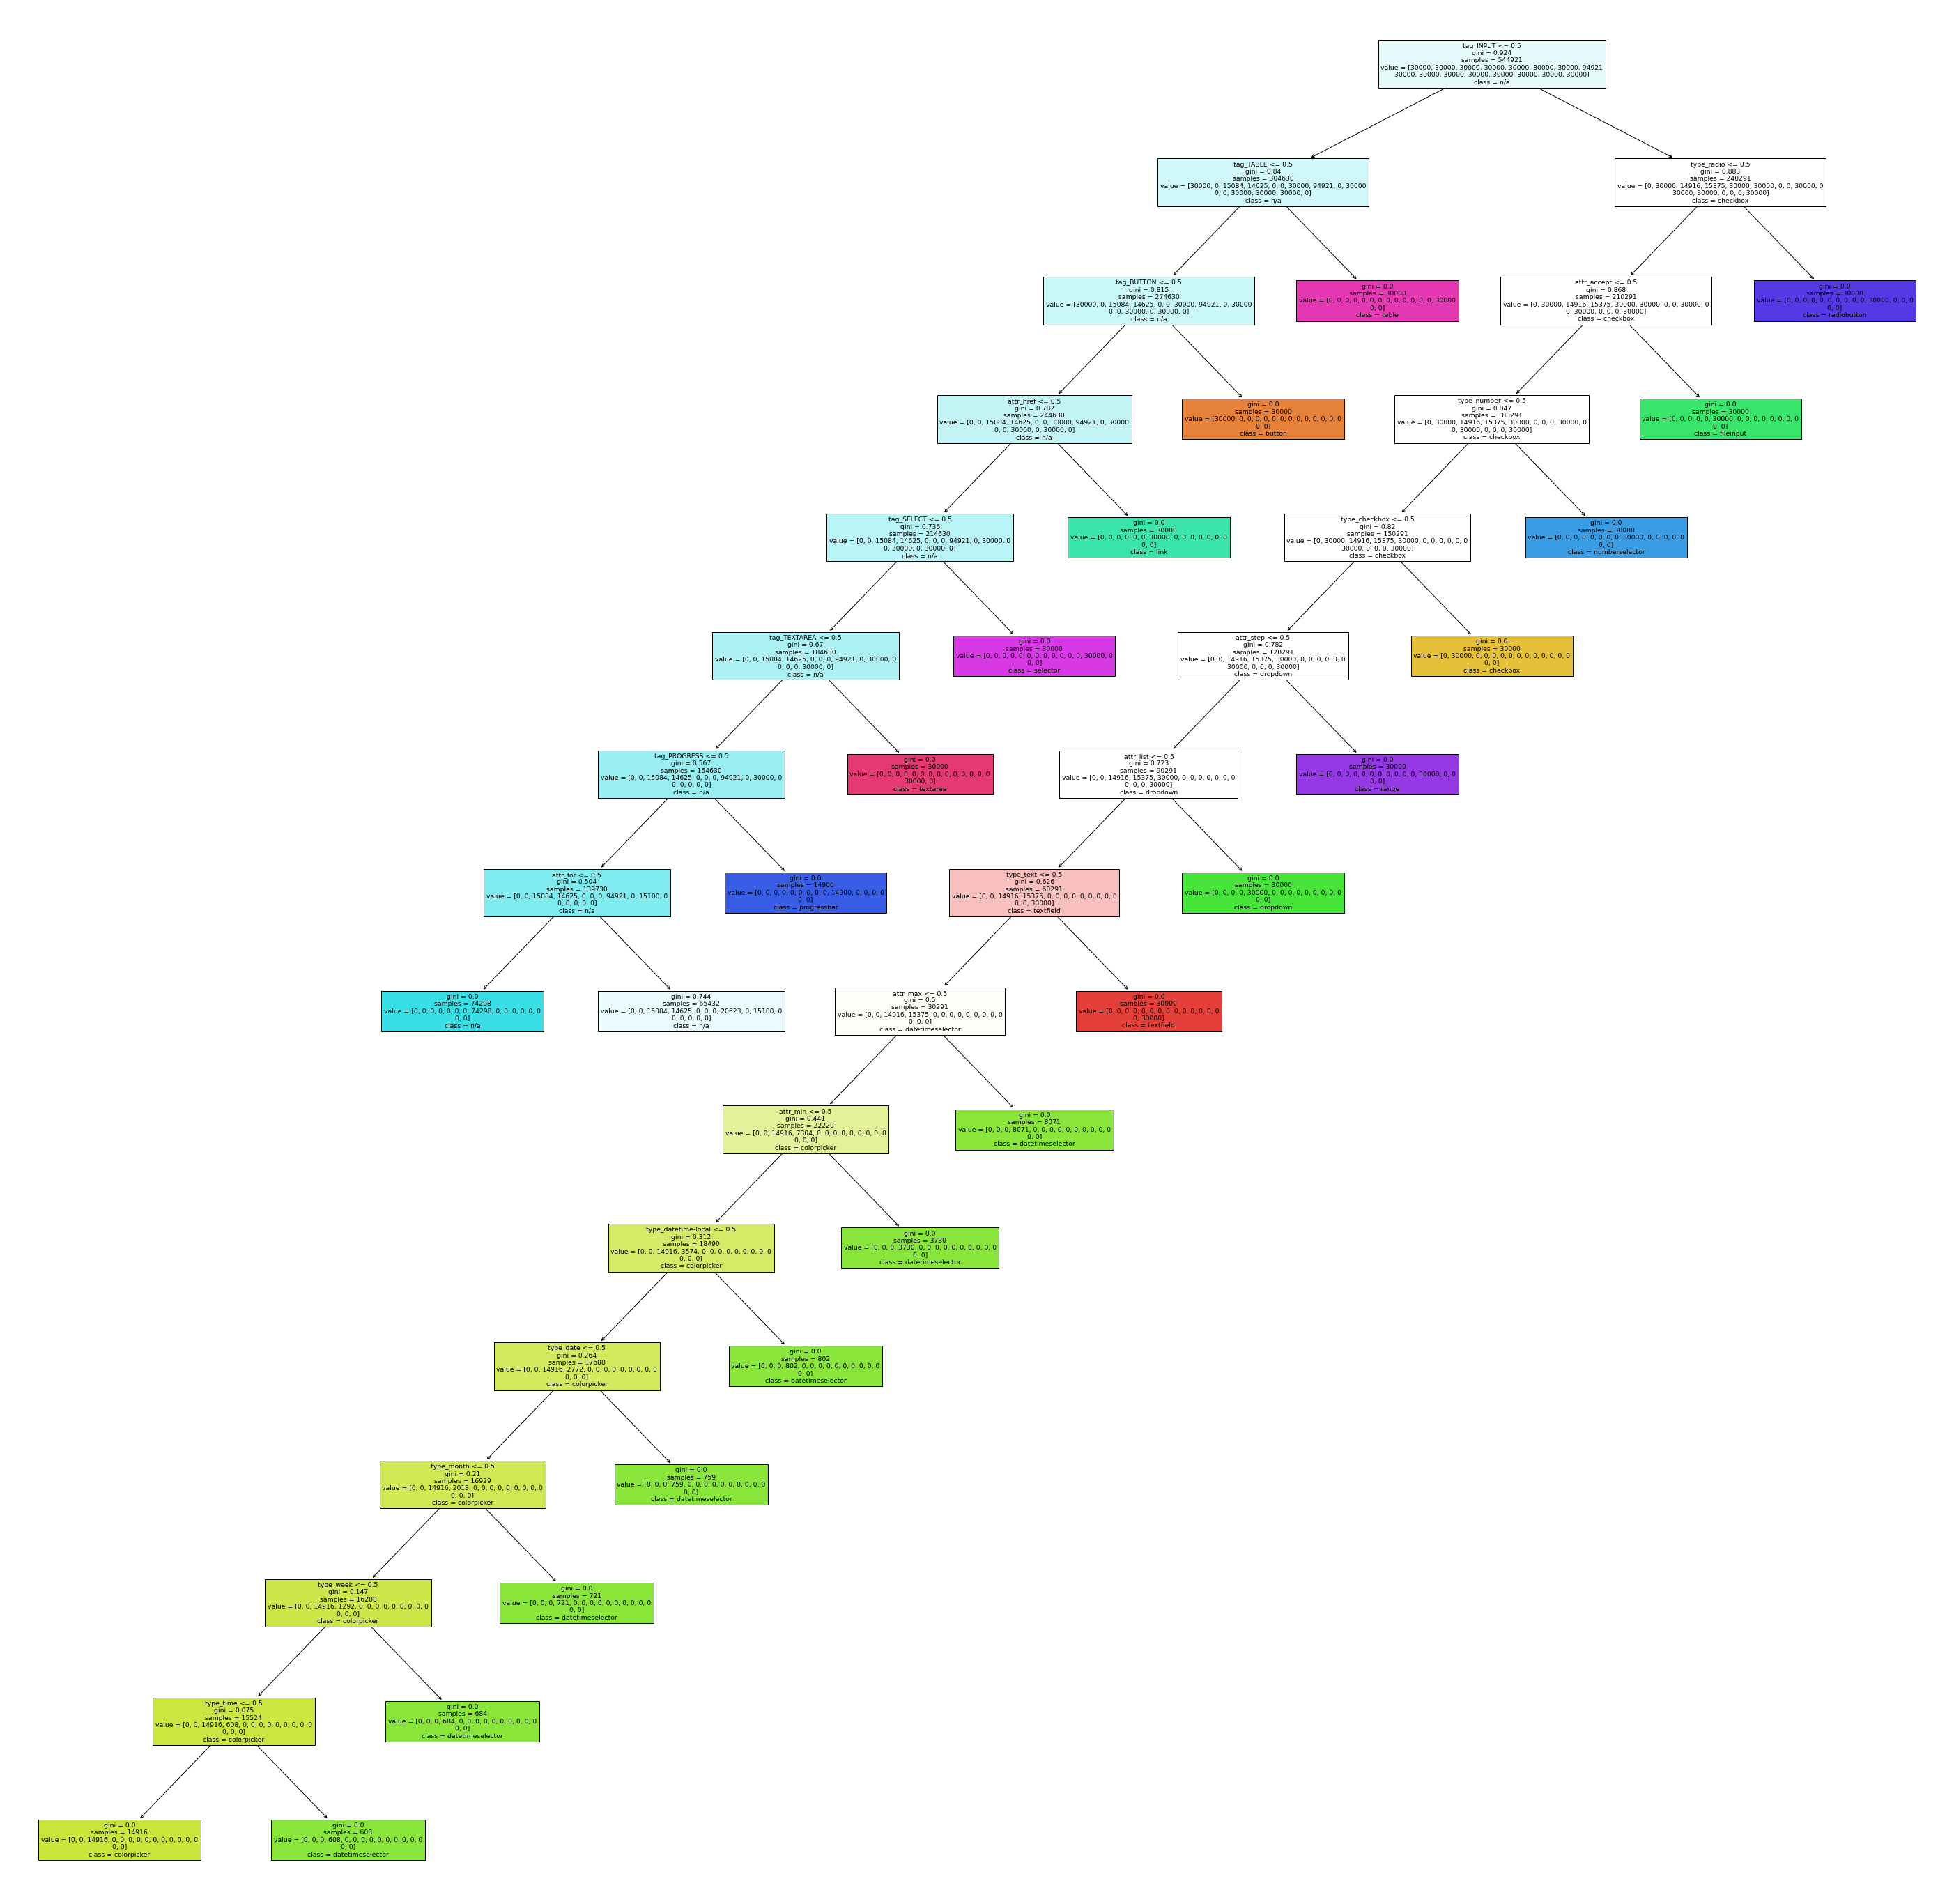

In [542]:
from sklearn import tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(50,50))
_ = tree.plot_tree(tree_model, 
                   feature_names=X_train.columns,  
                   class_names=le.classes_,
                   filled=True)